# Data extraction

### Downloading and Converting Mammography Images from DDSM thumbnails

In [2]:
import os
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
from PIL import Image

def download_images(url, dest_folder):
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)

    try:
        response = requests.get(url)
        response.raise_for_status()
    except requests.exceptions.HTTPError as err:
        print(f"Error: {err}")
        return

    soup = BeautifulSoup(response.text, 'html.parser')
    img_tags = soup.find_all('img')
    urls = [img['src'] for img in img_tags if 'src' in img.attrs]

    for img_url in urls:
        img_url = urljoin(url, img_url)
        img_name = os.path.join(dest_folder, os.path.basename(img_url))
        if len(img_name) > 255:  # Check for path length
            print(f"Skipping {img_name}: path length exceeds 255 characters")
            continue

        try:
            img_data = requests.get(img_url).content
            with open(img_name, 'wb') as f:
                f.write(img_data)
            convert_to_png(img_name)
            os.remove(img_name)  # Remove original file after conversion
            print(f"Downloaded and converted {img_name} to PNG")
        except Exception as e:
            print(f"Failed to download or convert {img_url}: {e}")

def convert_to_png(img_path):
    try:
        with Image.open(img_path) as img:
            png_path = os.path.splitext(img_path)[0] + '.png'
            img.save(png_path, 'PNG')
    except Exception as e:
        print(f"Failed to convert {img_path} to PNG: {e}")

def main():
    base_base_url = "http://www.eng.usf.edu/cvprg/Mammography/DDSM/thumbnails/normals/"
    normal_ranges = {
        'normal_02': (200, 329),
        'normal_03': (330, 392),
        'normal_04': (412, 479),
        'normal_05': (482, 562),
        'normal_06': (565, 711),
        'normal_07': (4500, 4594),
        'normal_08': (4548, 4609),
        'normal_09': (3600, 3659),
        'normal_10': (3660, 3682),
        'normal_11': (1955, 2022),
        'normal_12': (2023, 2043)
    }

    dest_folder = "C:/Users/Emilio Venegas/Documents/python/Machine_learning/Breast_mammography/normal_mammography"
    
    for normal, (start, end) in normal_ranges.items():
        base_url = f"{base_base_url}{normal}/case"
        case_numbers = [f"{i:04d}" for i in range(start, end + 1)]
        for case_num in case_numbers:
            page_url = f"{base_url}{case_num}/A-{case_num}-1.html"
            print(f"Processing {page_url}")
            download_images(page_url, dest_folder)

if __name__ == "__main__":
    main()


Processing http://www.eng.usf.edu/cvprg/Mammography/DDSM/thumbnails/normals/normal_02/case0200/A-0200-1.html
Downloaded and converted C:/Users/Emilio Venegas/Documents/python/Machine_learning/Breast_mammography/normal_mammography\A_0200_1.LEFT_MLO.LJPEG.1_highpass.gif to PNG
Downloaded and converted C:/Users/Emilio Venegas/Documents/python/Machine_learning/Breast_mammography/normal_mammography\A_0200_1.RIGHT_MLO.LJPEG.1_highpass.gif to PNG
Downloaded and converted C:/Users/Emilio Venegas/Documents/python/Machine_learning/Breast_mammography/normal_mammography\A_0200_1.LEFT_CC.LJPEG.1_highpass.gif to PNG
Downloaded and converted C:/Users/Emilio Venegas/Documents/python/Machine_learning/Breast_mammography/normal_mammography\A_0200_1.RIGHT_CC.LJPEG.1_highpass.gif to PNG
Processing http://www.eng.usf.edu/cvprg/Mammography/DDSM/thumbnails/normals/normal_02/case0201/A-0201-1.html
Downloaded and converted C:/Users/Emilio Venegas/Documents/python/Machine_learning/Breast_mammography/normal_mammo

### Data augmentation for normal mammography

In [16]:
import os
from PIL import Image
import random

def data_augmentation(input_image_path, output_folder, target_size=(227, 227)):
    # Open the input image
    original_image = Image.open(input_image_path).convert("RGBA")
    
    # Rotate the image by a random angle between -30 and 30 degrees
    angle = random.randint(-30, 30)
    rotated_image = original_image.rotate(angle, expand=True, resample=Image.BICUBIC)
    
    # Create a new black background image with the size of the rotated image
    black_background = Image.new("RGBA", rotated_image.size, color=(0, 0, 0, 255))
    
    # Paste the rotated image onto the black background
    black_background.paste(rotated_image, (0, 0), rotated_image)
    rotated_image = black_background.convert("RGB")
    
    # Zoom the image by randomly scaling between 0.8 to 1.2
    scale_factor = random.uniform(0.8, 1.2)
    scaled_width = int(rotated_image.width * scale_factor)
    scaled_height = int(rotated_image.height * scale_factor)
    zoomed_image = rotated_image.resize((scaled_width, scaled_height), resample=Image.BICUBIC)
    
    # Ensure that the image is 227x227 by cropping
    if zoomed_image.width != target_size[0] or zoomed_image.height != target_size[1]:
        # Crop the image to the center
        left = (zoomed_image.width - target_size[0]) // 2
        top = (zoomed_image.height - target_size[1]) // 2
        right = left + target_size[0]
        bottom = top + target_size[1]
        cropped_image = zoomed_image.crop((left, top, right, bottom))
    else:
        cropped_image = zoomed_image
    
    # Create a new black background image with the target size
    final_image = Image.new("RGB", target_size, color='black')
    
    # Calculate the position to paste the cropped image onto the black background
    x_offset = (target_size[0] - cropped_image.width) // 2
    y_offset = (target_size[1] - cropped_image.height) // 2
    
    # Paste the cropped image onto the black background
    final_image.paste(cropped_image, (x_offset, y_offset))
    
    # Invert the image (horizontal flip)
    inverted_image = final_image.transpose(Image.FLIP_LEFT_RIGHT)
    
    # Save the augmented image
    output_image_path = os.path.join(output_folder, os.path.basename(input_image_path))
    inverted_image.save(output_image_path)

def augment_images(input_folder, output_folder):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Process each image in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith(('.jpg', '.jpeg', '.png')):  # Process only image files
            input_image_path = os.path.join(input_folder, filename)
            data_augmentation(input_image_path, output_folder)

# Input and output directories with backslashes flipped
input_folder = "C:/Users/Emilio Venegas/Documents/python/Machine_learning/Breast_mammography/normal_mammography"
output_folder = "C:/Users/Emilio Venegas/Documents/python/Machine_learning/Breast_mammography/augmented_images"

# Augment images
augment_images(input_folder, output_folder)


### Rename function and Rename files in normal data set

In [3]:
import os

def rename_files_in_directory(directory_path, prefix):
    # List all files in the directory
    files = os.listdir(directory_path)
    
    # Filter out directories, we only want to rename files
    files = [f for f in files if os.path.isfile(os.path.join(directory_path, f))]
    
    # Sort files to maintain a consistent order (optional)
    files.sort()

    # Rename files
    for index, filename in enumerate(files):
        # Construct new file name
        new_name = f"{prefix}{index + 1}.png"
        
        # Get full file paths
        old_file = os.path.join(directory_path, filename)
        new_file = os.path.join(directory_path, new_name)
        
        # Rename the file
        os.rename(old_file, new_file)
        print(f"Renamed '{old_file}' to '{new_file}'")

# Usage
directory_path = 'C:/Users/Emilio Venegas/Documents/python/Machine_learning/Breast_mammography/augmented_images'
prefix = 'normal'
rename_files_in_directory(directory_path, prefix)


Renamed 'C:/Users/Emilio Venegas/Documents/python/Machine_learning/Breast_mammography/augmented_images\normal_aug1.png' to 'C:/Users/Emilio Venegas/Documents/python/Machine_learning/Breast_mammography/augmented_images\normal1.png'
Renamed 'C:/Users/Emilio Venegas/Documents/python/Machine_learning/Breast_mammography/augmented_images\normal_aug10.png' to 'C:/Users/Emilio Venegas/Documents/python/Machine_learning/Breast_mammography/augmented_images\normal2.png'
Renamed 'C:/Users/Emilio Venegas/Documents/python/Machine_learning/Breast_mammography/augmented_images\normal_aug100.png' to 'C:/Users/Emilio Venegas/Documents/python/Machine_learning/Breast_mammography/augmented_images\normal3.png'
Renamed 'C:/Users/Emilio Venegas/Documents/python/Machine_learning/Breast_mammography/augmented_images\normal_aug1000.png' to 'C:/Users/Emilio Venegas/Documents/python/Machine_learning/Breast_mammography/augmented_images\normal4.png'
Renamed 'C:/Users/Emilio Venegas/Documents/python/Machine_learning/Bre

### Rename malignant and benign

In [90]:
rename_files_in_directory("C:/Users/Emilio Venegas/Documents/python/Machine_learning/Breast_mammography/Dataset of Mammography with Benign Malignant Breast Masses/INbreast+MIAS+DDSM Dataset/malignant", "malignant")
rename_files_in_directory("C:/Users/Emilio Venegas/Documents/python/Machine_learning/Breast_mammography/Dataset of Mammography with Benign Malignant Breast Masses/INbreast+MIAS+DDSM Dataset/benign", "benign")

# Image processing with CLAHE (Contrast Limited Adaptive histogram equalization)

### Define CLAHE function

In [15]:
import cv2
import os

def apply_clahe_to_folder(input_dir, output_dir):
    """
    Applies CLAHE to all PNG images in the specified input directory and saves the enhanced images to the output directory.
    
    Parameters:
    - input_dir: str, path to the input directory containing PNG images.
    - output_dir: str, path to the output directory to save enhanced images.
    """
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Function to apply CLAHE to an image
    def apply_clahe(img):
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        return clahe.apply(img)
    
    # Loop through all files in the input directory
    for filename in os.listdir(input_dir):
        if filename.endswith('.png'):  # Check if the file is a PNG image
            # Construct the full path to the image
            img_path = os.path.join(input_dir, filename)
            
            # Load the image in grayscale
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            
            # Check if the image is loaded correctly
            if img is None:
                print(f"Error: Could not open or find the image {img_path}.")
                continue
            
            # Apply CLAHE to the grayscale image
            clahe_img = apply_clahe(img)
            
            # Construct the full path for the output image
            output_path = f"{output_dir}/{filename}"
            
            # Save the CLAHE-enhanced image
            cv2.imwrite(output_path, clahe_img)
            
            print(f"Processed and saved: {output_path}")
    
    print("Processing completed.")

# Example usage:
# apply_clahe_to_folder('path_to_input_directory', 'path_to_output_directory')


### Apply CLAHE for images

In [91]:
apply_clahe_to_folder("C:/Users/Emilio Venegas/Documents/python/Machine_learning/Breast_mammography/Dataset of Mammography with Benign Malignant Breast Masses/INbreast+MIAS+DDSM Dataset/malignant", "C:/Users/Emilio Venegas/Documents/python/Machine_learning/CLAHE_images/malignant")
apply_clahe_to_folder("C:/Users/Emilio Venegas/Documents/python/Machine_learning/Breast_mammography/Dataset of Mammography with Benign Malignant Breast Masses/INbreast+MIAS+DDSM Dataset/benign", "C:/Users/Emilio Venegas/Documents/python/Machine_learning/CLAHE_images/benign")
apply_clahe_to_folder("C:/Users/Emilio Venegas/Documents/python/Machine_learning/Breast_mammography/Dataset of Mammography with Benign Malignant Breast Masses/INbreast+MIAS+DDSM Dataset/normal", "C:/Users/Emilio Venegas/Documents/python/Machine_learning/CLAHE_images/normal")


### Loading Image File Names

In [31]:
import cv2
import os
normal_img = os.listdir("C:/Users/Emilio Venegas/Documents/python/Machine_learning/CLAHE_images/normal")
benign_img = os.listdir("C:/Users/Emilio Venegas/Documents/python/Machine_learning/CLAHE_images/benign")
malign_img = os.listdir("C:/Users/Emilio Venegas/Documents/python/Machine_learning/CLAHE_images/malignant")



### Analyzing Image Data Distribution

In [32]:
normal_num = len(normal_img)  # No cancer
benign_num = len(benign_img)   # Benign cancer 
malign_num = len(malign_img)   # Malign cancer 
        
total_img_num = normal_num + benign_num + malign_num
        
print('Number of Images of no cancer: {}' .format(normal_num))   # images of Non cancer
print('Number of Images of benign cancer : {}' .format(benign_num))   # images of benign cancer 
print('Number of Images of malign cancer : {}' .format(malign_num))   # images of malign cancer 
print('Total Number of Images : {}' .format(total_img_num))

Number of Images of no cancer: 2026
Number of Images of benign cancer : 10866
Number of Images of malign cancer : 13710
Total Number of Images : 26602


# CNN for Multi-Class Image Classification with TensorFlow

### Importing Libraries and Setting Random Seed

In [33]:
import os
from os import listdir
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 



import cv2
from matplotlib.image import imread

import tensorflow as tf
from keras.utils import to_categorical
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


import glob
import PIL
import random

random.seed(100)

### Displaying Randomly Sampled Images from Different Classes

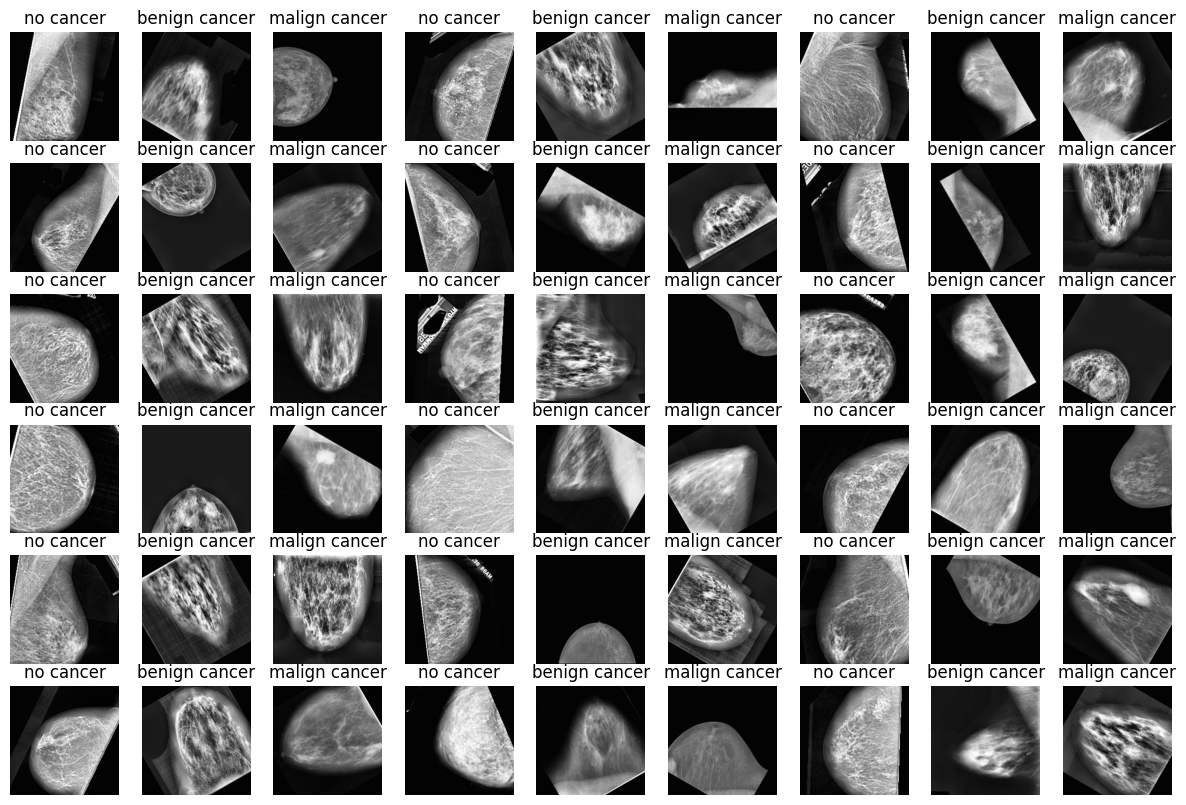

In [34]:
import cv2
import os

plt.figure(figsize = (15, 15))

some_non = np.random.randint(0, len(normal_img), 18)
some_bcan = np.random.randint(0, len(benign_img), 18)
some_mcan = np.random.randint(0, len(malign_img), 18)

s = 1
for num in some_non:
    
        img = image.load_img((f"C:/Users/Emilio Venegas/Documents/python/Machine_learning/CLAHE_images/normal/{normal_img[num]}"), target_size=(227, 227))
        img = image.img_to_array(img)
        
        plt.subplot(9, 9, 3*s-2)
        plt.axis('off')
        plt.title('no cancer')
        plt.imshow(img.astype('uint8'))
        s += 1
        
s = 1
for num in some_bcan:
    
        img = image.load_img((f"C:/Users/Emilio Venegas/Documents/python/Machine_learning/CLAHE_images/benign/{benign_img[num]}"), target_size=(227, 227))
        img = image.img_to_array(img)
        plt.subplot(9, 9, 3*s-1)
        plt.axis('off')        
        plt.title('benign cancer')
        plt.imshow(img.astype('uint8'))
        s += 1
s = 1
for num in some_mcan:
    
        img = image.load_img((f"C:/Users/Emilio Venegas/Documents/python/Machine_learning/CLAHE_images/malignant/{malign_img[num]}"), target_size=(227, 227))
        img = image.img_to_array(img)
        plt.subplot(9, 9, 3*s)
        plt.axis('off')        
        plt.title('malign cancer')
        plt.imshow(img.astype('uint8'))
        s += 1

### Sampling, Resizing, and Labeling Images for Model Training

In [35]:
# Randomly sample images from two lists, 'non_cancer_imgs' and 'cancer_imgs'
some_nor = random.sample(normal_img, len(normal_img))
some_ben = random.sample(benign_img, len(benign_img))
some_mal = random.sample(malign_img, len(malign_img))

# Initialize empty arrays to store image data and labels
nor_img_arr = []  # Array for non-cancer images
ben_img_arr = []  # Array for ben-cancer images
mal_img_arr = []  # Array for mal-cancer images


# Loop through each image in the 'some_nor' list
for img in some_nor:
    # Read the image in color mode
    n_img = cv2.imread(f"C:/Users/Emilio Venegas/Documents/python/Machine_learning/CLAHE_images/normal/{img}", cv2.IMREAD_GRAYSCALE)
    # Resize the image to a fixed size (227x 227 pixels) using linear interpolation
    n_img_size = cv2.resize(n_img, (227, 227), interpolation=cv2.INTER_LINEAR)
    # Append the resized image and label 0 (indicating non-cancer) to the 'nor_img_arr'
    nor_img_arr.append([n_img_size, 0])

# Loop through each image in the 'some_ben' list
for img in some_ben:
    # Read the image in color mode
    n_img = cv2.imread(f"C:/Users/Emilio Venegas/Documents/python/Machine_learning/CLAHE_images/benign/{img}", cv2.IMREAD_GRAYSCALE)
    # Resize the image to a fixed size (227x 227 pixels) using linear interpolation
    n_img_size = cv2.resize(n_img, (227, 227), interpolation=cv2.INTER_LINEAR)
    # Append the resized image and label 1 (indicating benign-cancer) to the 'ben_img_arr'
    ben_img_arr.append([n_img_size, 1])

# Loop through each image in the 'some_mal' list
for img in some_mal:
    # Read the image in color mode
    n_img = cv2.imread(f"C:/Users/Emilio Venegas/Documents/python/Machine_learning/CLAHE_images/malignant/{img}", cv2.IMREAD_GRAYSCALE)
    # Resize the image to a fixed size (227x 227 pixels) using linear interpolation
    n_img_size = cv2.resize(n_img, (227, 227), interpolation=cv2.INTER_LINEAR)
    # Append the resized image and label 2 (indicating malignant-cancer) to the 'mal_img_arr'
    mal_img_arr.append([n_img_size, 2])



### Concatenation and Shuffling Image Data for Model Training

In [90]:
some_nor.index("normal1.png")

699

In [114]:
a = some_nor.index("normal1.png")
test_array =breast_img_arr[a][0]
index = 0
for i in range(len(X)):
    if np.array_equal(test_array, X[i]):
        index = i
        print(index)
y[index]

In [ ]:
folder_path = 'C:/Users/Emilio Venegas/Documents/python/Machine_learning/CLAHE_images/normal'

In [120]:
import os
import numpy as np

def find_match_index(test_array, target_arrays):
    """Find the index of test_array in target_arrays."""
    for i in range(len(target_arrays)):
        if np.array_equal(test_array, target_arrays[i]):
            return i
    return None

def process_folder(folder_path, some_nor, breast_img_arr, X, y):
    """Process all files in the folder and return a list of y values at found indices."""
    matched_y_values = []

    for filename in os.listdir(folder_path):
        # Get the index of the file in some_nor
        try:
            a = some_nor.index(filename)
        except ValueError:
            print(f"File {filename} not found in some_nor.")
            continue
        
        # Get the test array from breast_img_arr
        test_array = breast_img_arr[a][0]
        
        # Find the match index in X
        index = find_match_index(test_array, X)
        
        if index is not None:
            # Append the corresponding y value
            matched_y_values.append(y[index])
            
        
    return matched_y_values

# Example usage
folder_path = 'C:/Users/Emilio Venegas/Documents/python/Machine_learning/CLAHE_images/normal'


matched_y_values = process_folder(folder_path, some_nor, breast_img_arr, X, y)
print("Matched y values:", matched_y_values)


Matched y values: [1, 2, 1, 1, 0, 0, 1, 2, 1, 2, 2, 2, 0, 1, 2, 0, 2, 1, 1, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 2, 0, 2, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 2, 0, 0, 2, 2, 2, 1, 2, 2, 0, 2, 2, 2, 1, 0, 1, 2, 0, 2, 0, 0, 0, 2, 1, 1, 0, 2, 1, 1, 1, 0, 1, 2, 2, 0, 0, 2, 2, 1, 2, 2, 1, 2, 0, 2, 1, 0, 2, 0, 1, 1, 2, 0, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 2, 1, 0, 0, 0, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 0, 2, 2, 1, 2, 1, 2, 0, 1, 2, 2, 0, 2, 2, 2, 0, 0, 1, 2, 1, 0, 2, 1, 2, 0, 2, 2, 0, 2, 0, 2, 2, 1, 2, 1, 2, 2, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 0, 2, 1, 2, 2, 0, 0, 2, 1, 0, 1, 2, 0, 2, 0, 2, 2, 2, 2, 1, 2, 0, 2, 2, 0, 2, 0, 2, 1, 1, 2, 1, 2, 2, 1, 0, 1, 0, 0, 2, 2, 2, 2, 1, 1, 2, 0, 1, 1, 1, 0, 2, 2, 0, 2, 0, 1, 1, 0, 2, 2, 1, 1, 0, 0, 0, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 0, 0, 0, 0, 2, 0, 0, 2, 0, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 1, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 0, 1, 0, 0, 1, 2, 2, 2, 0, 

In [129]:
breast_img_arr = nor_img_arr*5 + ben_img_arr + mal_img_arr


In [131]:
breast_img_arr[228][1]

0

In [136]:
from tensorflow.keras.preprocessing import image

X = []  # List for image data
y = []  # List for labels

breast_img_arr = nor_img_arr*5 + ben_img_arr + mal_img_arr

# Shuffle the elements in the 'breast_img_arr' array randomly
random.shuffle(breast_img_arr)

for feature, label in breast_img_arr:
    # Append the image data (feature) to the 'X' list
    X.append(feature)
    # Append the label to the 'y' list
    y.append(label)
X = np.array(X)
y = np.array(y)

print('X shape: {}'.format(X_np.shape))

X shape: (34706, 227, 227)


### Proportion of normal mammography after oversampling data

In [137]:
#Proportion of normal mammography
nor = 0
for i in range(len(breast_img_arr)):
    if breast_img_arr[i][1] == 0:
        nor += 1
    
print(nor/len(breast_img_arr))

    

0.2918803665072322


### Data spliting

In [147]:
# Split the dataset into training and testing sets, with a test size of 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=40)

# Define a rate (percentage) for subsampling the training data
rate = 0.5

# Calculate the number of samples to keep in the training data based on the rate
num = int(X.shape[0] * rate)

# Convert the categorical labels in 'y_train' and 'y_test' to one-hot encoded format
y_train = to_categorical(y_train, 3)  # Assuming there are 3 classes 
y_test = to_categorical(y_test, 3)


print('X_train shape : {}' .format(X_train.shape))
print('X_test shape : {}' .format(X_test.shape))
print('y_train shape : {}' .format(y_train.shape))
print('y_test shape : {}' .format(y_test.shape))

X_train shape : (27764, 227, 227)
X_test shape : (6942, 227, 227)
y_train shape : (27764, 3)
y_test shape : (6942, 3)


### Early stopping

In [39]:
# Define an EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)

### Compiling CNN for Multi-Class Image Classification

In [40]:
X_train = np.array(X_train).reshape(-1, 227, 227, 1)  # Ensure X has the right shape
X_test = np.array(X_test).reshape(-1, 227, 227, 1)
y_train = np.array(y_train)  # Ensure y is in the correct format
y_test = np.array(y_test)

### Model architechture and compiling

In [41]:


# Set a random seed for reproducibility
tf.random.set_seed(42)

# Create a Sequential model
model = tf.keras.Sequential([
    # Convolutional layer with 32 filters, a 3x3 kernel, 'same' padding, and ReLU activation
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(227, 227, 1)),
    tf.keras.layers.BatchNormalization(),
    # MaxPooling layer with a 2x2 pool size and default stride (2)
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    
    # Convolutional layer with 64 filters, a 3x3 kernel, 'same' padding, and ReLU activation
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    # MaxPooling layer with a 3x3 pool size and stride of 2
    tf.keras.layers.MaxPooling2D((3, 3), strides=2),
    
    # Convolutional layer with 128 filters, a 3x3 kernel, 'same' padding, and ReLU activation
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    # MaxPooling layer with a 3x3 pool size and stride of 2
    tf.keras.layers.MaxPooling2D((3, 3), strides=2),
    
    # Convolutional layer with 128 filters, a 3x3 kernel, 'same' padding, and ReLU activation
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    # MaxPooling layer with a 3x3 pool size and stride of 2
    tf.keras.layers.MaxPooling2D((3, 3), strides=2),
    
    # Flatten the output to prepare for fully connected layers
    tf.keras.layers.Flatten(),
    
    # Fully connected layer with 128 units and ReLU activation
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    # Output layer with 3 units (multi-class classification) and softmax activation
    tf.keras.layers.Dense(3, activation='softmax')
])

# Display a summary of the model architecture
model.summary()

# Compile the model with Adam optimizer, categorical cross-entropy loss, and accuracy metric
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


c:\Users\Emilio Venegas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 227, 227, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 227, 227, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 113, 113, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 113, 113, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 113, 113, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 27, 27, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 27, 27, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 27, 27, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     2,769,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,011,075 (11.49 MB)

 Trainable params: 3,010,371 (11.48 MB)

 Non-trainable params: 704 (2.75 KB)

### Model fitting

In [82]:
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=25,
                    batch_size=75,
                    callbacks=[early_stopping, plateau])

Epoch 1/25
371/371 ━━━━━━━━━━━━━━━━━━━━ 1461s 4s/step - accuracy: 0.7624 - loss: 1.2547 - val_accuracy: 0.8577 - val_loss: 0.2740 - learning_rate: 0.0010
Epoch 2/25
371/371 ━━━━━━━━━━━━━━━━━━━━ 1470s 4s/step - accuracy: 0.8599 - loss: 0.2750 - val_accuracy: 0.7674 - val_loss: 0.7445 - learning_rate: 0.0010
Epoch 3/25
371/371 ━━━━━━━━━━━━━━━━━━━━ 1425s 4s/step - accuracy: 0.8715 - loss: 0.2493 - val_accuracy: 0.8519 - val_loss: 0.3926 - learning_rate: 0.0010
Epoch 4/25
371/371 ━━━━━━━━━━━━━━━━━━━━ 1374s 4s/step - accuracy: 0.8887 - loss: 0.2129 - val_accuracy: 0.8944 - val_loss: 0.2052 - learning_rate: 1.0000e-04
Epoch 5/25
371/371 ━━━━━━━━━━━━━━━━━━━━ 1369s 4s/step - accuracy: 0.8965 - loss: 0.2006 - val_accuracy: 0.8967 - val_loss: 0.2006 - learning_rate: 1.0000e-04
Epoch 6/25
371/371 ━━━━━━━━━━━━━━━━━━━━ 1451s 4s/step - accuracy: 0.9009 - loss: 0.1916 - val_accuracy: 0.8819 - val_loss: 0.2138 - learning_rate: 1.0000e-04
Epoch 7/25
371/371 ━━━━━━━━━━━━━━━━━━━━ 1411s 4s/step - accuracy

In [84]:
# Save the model weights
model.save_weights('C:/Users/Emilio Venegas/Documents/python/Machine_learning/model_weights/model_weights.weights.h5')

### Load and Save model

In [42]:
# Load the weights
model.load_weights('C:/Users/Emilio Venegas/Documents/python/Machine_learning/model_weights/model_weights.weights.h5')
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

c:\Users\Emilio Venegas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [43]:
# Save model
model.save('C:/Users/Emilio Venegas/Documents/python/Machine_learning/model_weights/model.keras')

In [ ]:
# Load model
model.load('C:/Users/Emilio Venegas/Documents/python/Machine_learning/model_weights/model.keras')

In [81]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

def preprocess_image(img_path):
    # Load the image
    img = image.load_img(img_path, target_size=(227, 227), color_mode='grayscale')
    # Convert the image to a numpy array
    img_array = image.img_to_array(img)
    # Normalize the image (if needed, here assuming values are between 0 and 255)
    img_array = img_array / 255.0
    # Expand dimensions to match the input shape of the model (batch size of 1)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

In [47]:
import cv2
import numpy as np
from PIL import Image

def apply_clahe_to_png(input_path, output_path):
    # Read the image
    img = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        raise ValueError(f"Image at path {input_path} could not be loaded.")
    
    # Create a CLAHE object (Arguments are optional)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    
    # Apply CLAHE to the image
    clahe_img = clahe.apply(img)
    
    # Save the result as a PNG image
    cv2.imwrite(output_path, clahe_img)
    print(f"CLAHE applied and saved to {output_path}")

# Example usage:
input_path = 'path_to_your_input_image.png'
output_path = 'path_to_your_output_image.png'
apply_clahe_to_png(input_path, output_path)


CLAHE applied and saved to C:/Users/Emilio Venegas/Documents/python/Machine_learning/model_weights/mamocl.png


In [85]:
img_array_ben.shape

(1, 227, 227, 1)

In [84]:
img_path_ben = 'C:/Users/Emilio Venegas/Documents/python/Machine_learning/model_weights/normal2.png' 
img_array_ben = preprocess_image(img_path_ben)
predictions_ben = model.predict(img_array_ben)
predicted_class_ben = np.argmax(predictions_ben, axis=1)
print(f'Predicted class: {predicted_class_ben[0]}')

img_path_mal = 'C:/Users/Emilio Venegas/Documents/python/Machine_learning/model_weights/malignant6566.png' 
img_array_mal = preprocess_image(img_path_mal)
predictions_mal = model.predict(img_array_mal)
predicted_class_mal = np.argmax(predictions_mal, axis=1)
print(f'Predicted class: {predicted_class_mal[0]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted class: 2


In [57]:
model.predict(X_test)

217/217 ━━━━━━━━━━━━━━━━━━━━ 59s 272ms/step


array([[4.2133813e-08, 8.5133410e-01, 1.4866580e-01],
       [2.1153148e-06, 5.0753093e-01, 4.9246693e-01],
       [1.0000000e+00, 1.8865818e-13, 5.4552205e-12],
       ...,
       [1.0000000e+00, 0.0000000e+00, 7.3484938e-38],
       [1.4903273e-20, 2.4132130e-14, 1.0000000e+00],
       [6.4820327e-08, 6.5414119e-01, 3.4585872e-01]], dtype=float32)

### Confusion matrix

217/217 ━━━━━━━━━━━━━━━━━━━━ 61s 277ms/step


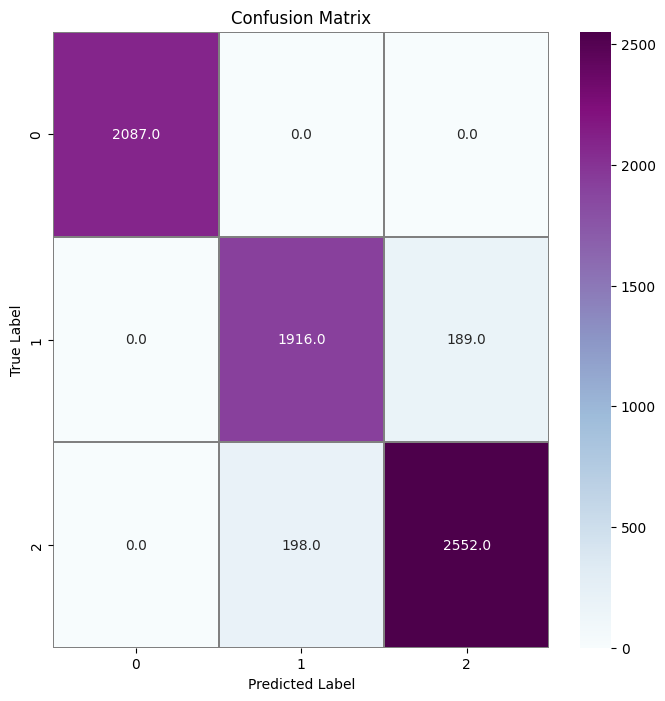

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you already have predictions and true labels
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(y_test, axis=1)  # Assuming y_test_one_hot is one-hot encoded

# Compute confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='.1f', cmap="BuPu", linewidths=0.01, linecolor="gray")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


### Model accuracy plot

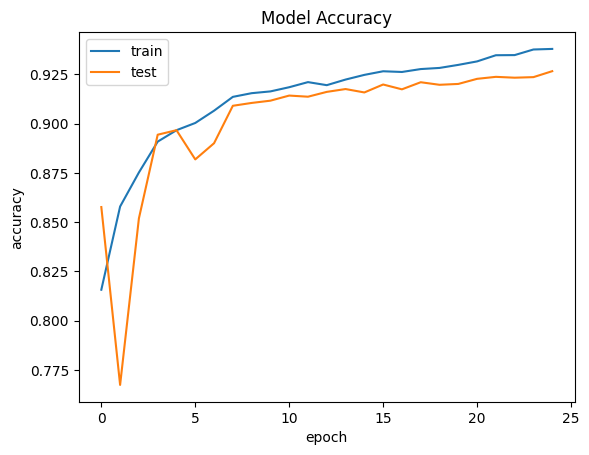

In [88]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Model loss plot

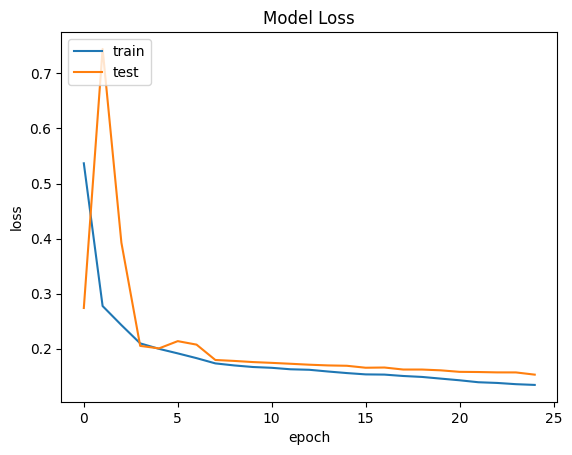

In [89]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()